In [1]:
import h5py
from compare import *
from lava_generator import *
from load_image_with_seed import *

In [2]:
DATASET = 'mnist_images/janus_dataset_comparison.h5'

In [3]:
vae = VAE.load("trained_models/VAE")
cnn = load_model("trained_models/CNN/classifier.h5")
xai = xai_model(vae.decoder, cnn, input_shape=(12,))

# input images
# janus_dataset = JanusDataset()
samples = np.array(h5py.File(DATASET, 'r').get('xn'))

adversarial_images = load_samples_from_janusdeep("mnist_images/np_data/mnist_dj")
samples_gen = [ad.image for ad in adversarial_images]
# samples_view = [janus_dataset.generate_digit(ad.seed) for ad in adversarial_images]
samples_view = [samples[int(ad.seed)] for ad in adversarial_images]
sample_labels_view = [ad.label for ad in adversarial_images]

x_view = np.reshape(samples_view, (-1, 784))
x_gen = np.reshape(samples_gen, (-1, 784))
y_onehot_view = tf.one_hot(tf.constant(sample_labels_view), depth=10).numpy()
h_view = vae.encoder.predict(x_view)

2024-06-04 11:19:18.253392: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


4/4 [==============================] - 0s 2ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 65ms/step
Misclassification achieved at iteration 0
1/1 [==============================] - 0s 32ms/step


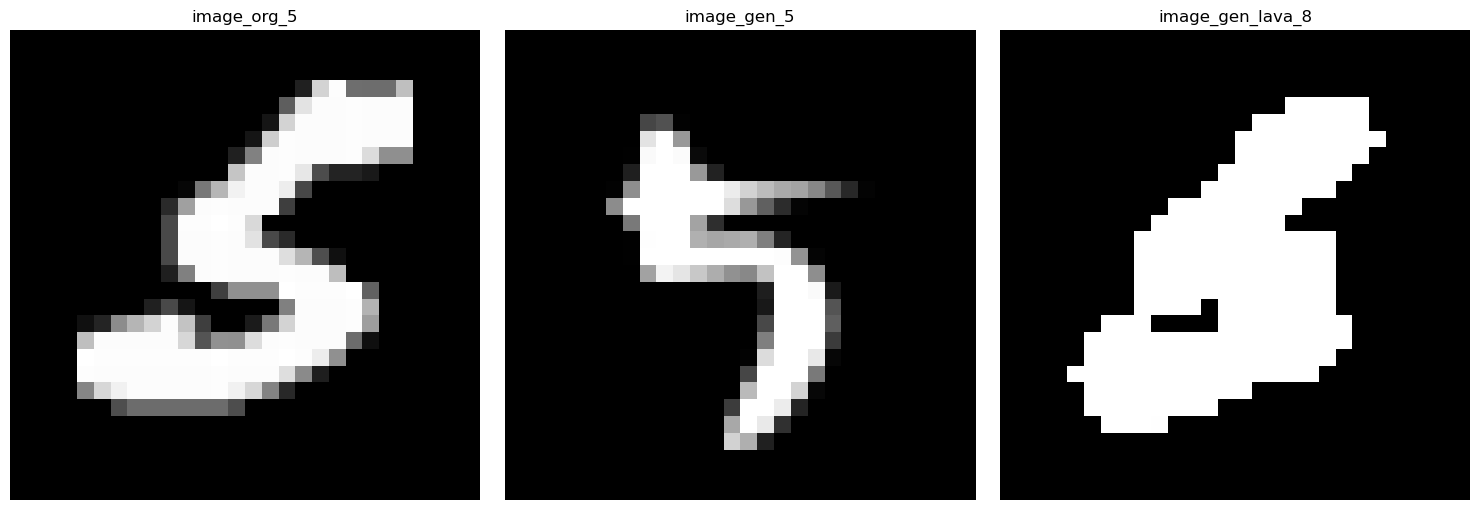

kl_fuzz: 0.6416053771972656
kl_lava: 0.7288187146186829
ws_fuzz: 0.0008868791381905329
ws_lava: 0.00036619717578686745
1/1 [==============================] - 0s 67ms/step
Misclassification achieved at iteration 0
1/1 [==============================] - 0s 21ms/step


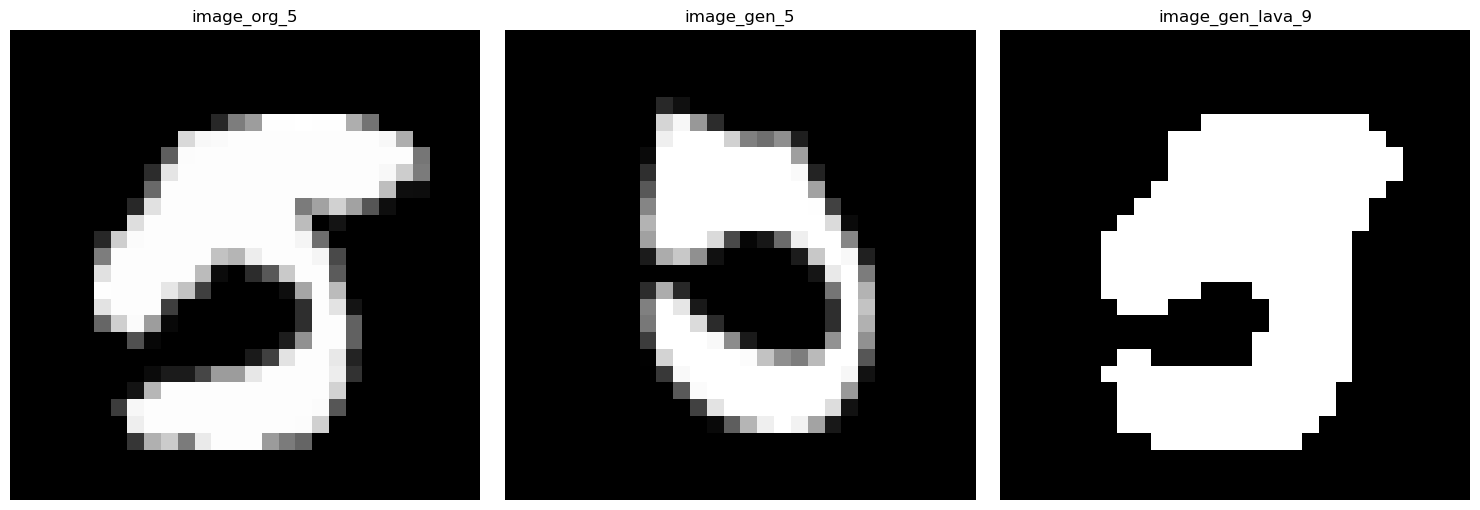

kl_fuzz: 0.45104658603668213
kl_lava: 0.37276485562324524
ws_fuzz: 0.0006282532033820848
ws_lava: 0.0003187141882660695
1/1 [==============================] - 0s 71ms/step
Misclassification achieved at iteration 0
1/1 [==============================] - 0s 22ms/step


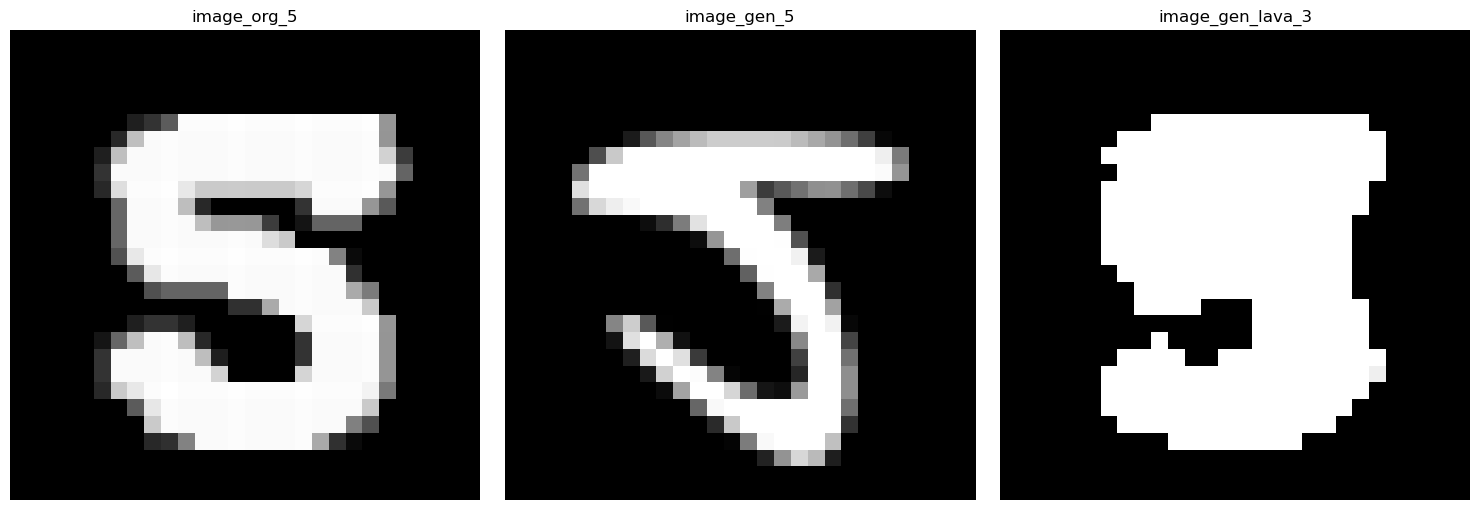

kl_fuzz: 0.3149740695953369
kl_lava: 0.4762718677520752
ws_fuzz: 0.0007438361929101176
ws_lava: 0.0002927240844087045
1/1 [==============================] - 0s 65ms/step
Misclassification achieved at iteration 0
1/1 [==============================] - 0s 20ms/step


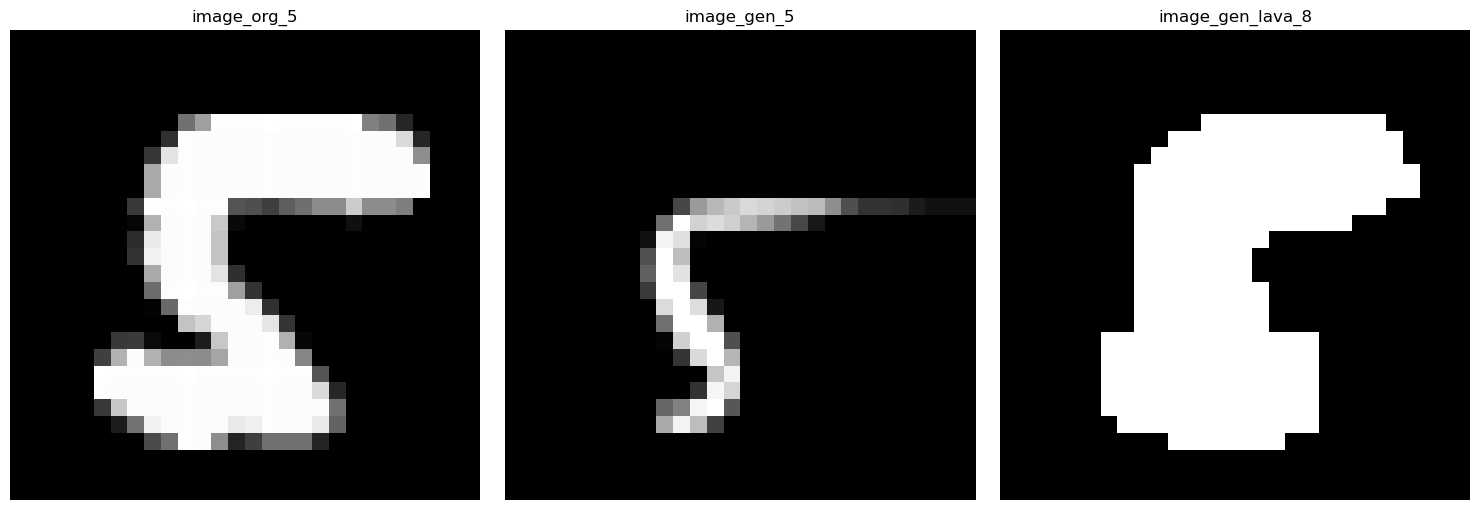

kl_fuzz: 0.45371323823928833
kl_lava: 0.36027780175209045
ws_fuzz: 0.0016773376556390145
ws_lava: 0.00035285101890919143
1/1 [==============================] - 0s 65ms/step
Misclassification achieved at iteration 0
1/1 [==============================] - 0s 18ms/step


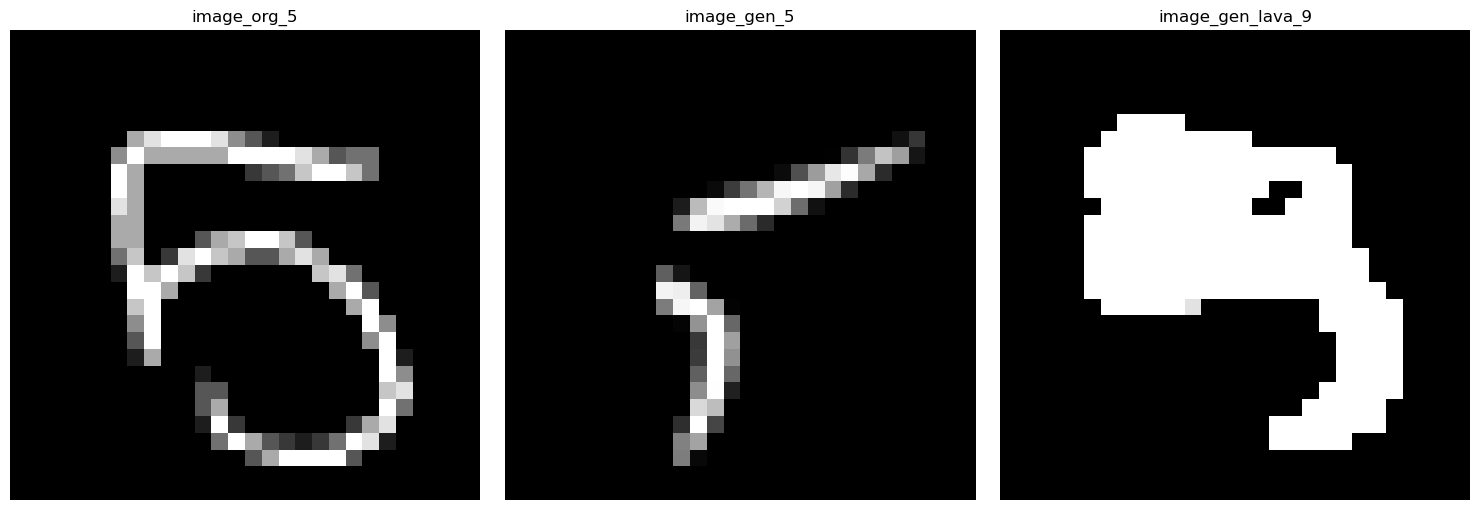

kl_fuzz: 1.876525640487671
kl_lava: 1.7039015293121338
ws_fuzz: 0.0009077478523568987
ws_lava: 0.0011063578794244056
1/1 [==============================] - 0s 62ms/step
Misclassification achieved at iteration 0
1/1 [==============================] - 0s 20ms/step


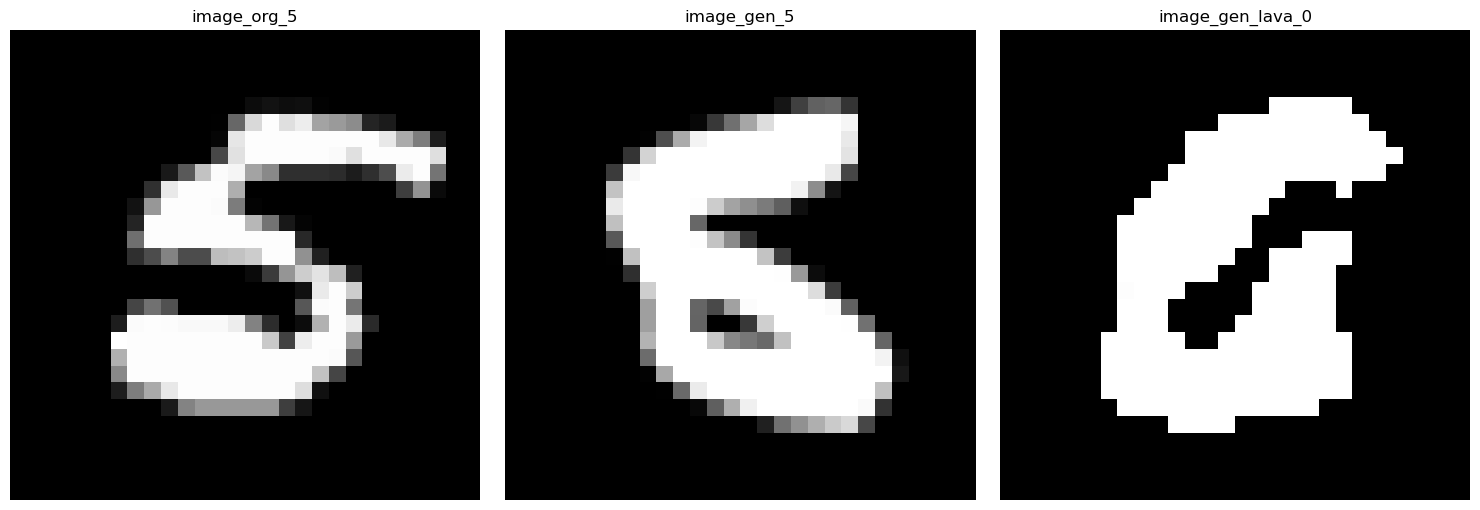

kl_fuzz: 0.6181958913803101
kl_lava: 0.7061799168586731
ws_fuzz: 0.00043983027675104883
ws_lava: 0.0005687713766449917
1/1 [==============================] - 0s 68ms/step
Misclassification achieved at iteration 0
1/1 [==============================] - 0s 19ms/step


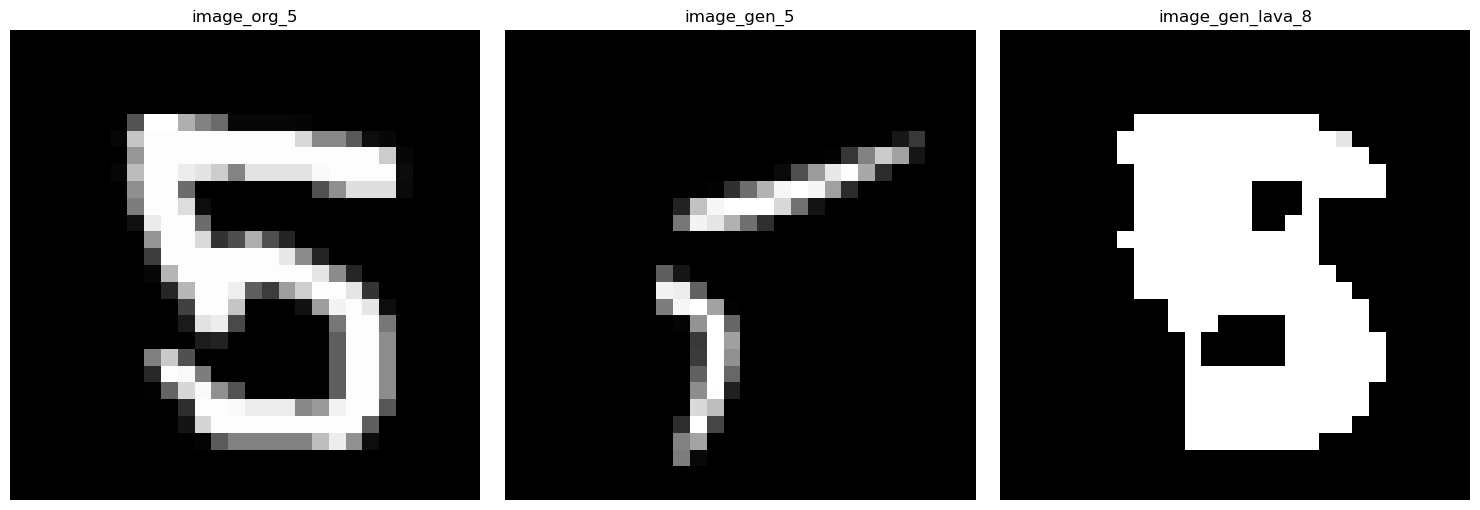

kl_fuzz: 1.162614107131958
kl_lava: 1.188962459564209
ws_fuzz: 0.0014942255135319638
ws_lava: 0.0005873973935895385
1/1 [==============================] - 0s 19ms/step
Misclassification achieved at iteration 4
1/1 [==============================] - 0s 19ms/step


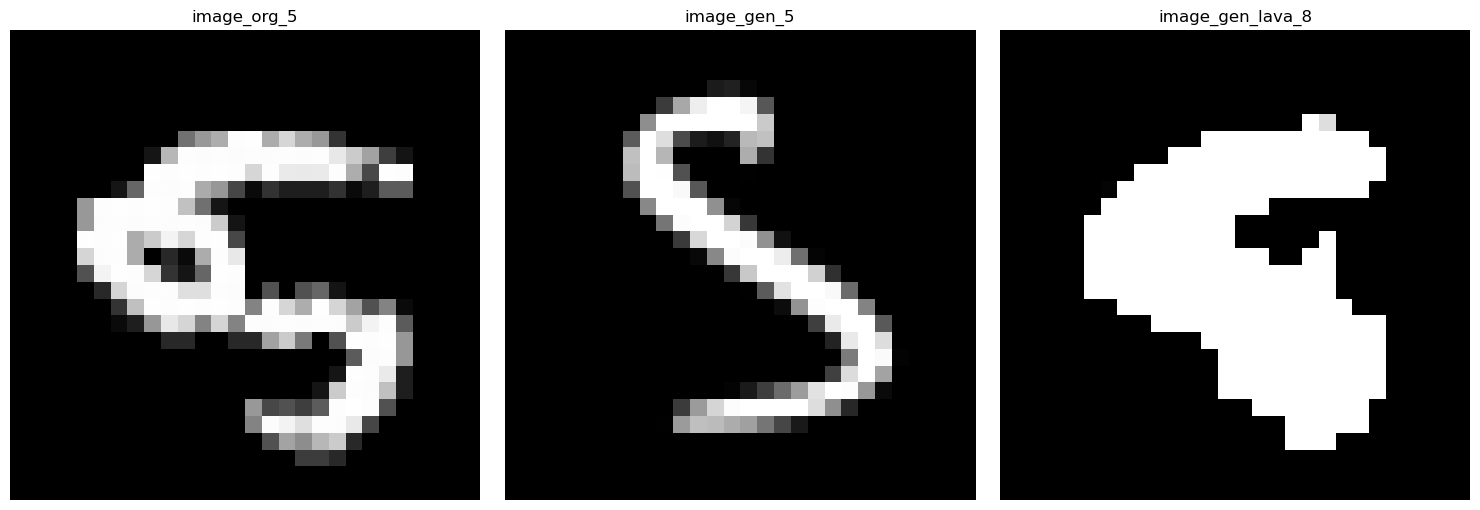

kl_fuzz: 0.9347426891326904
kl_lava: 0.33404451608657837
ws_fuzz: 0.0007172418317799272
ws_lava: 0.0005614629150135886
1/1 [==============================] - 0s 65ms/step
Misclassification achieved at iteration 0
1/1 [==============================] - 0s 20ms/step


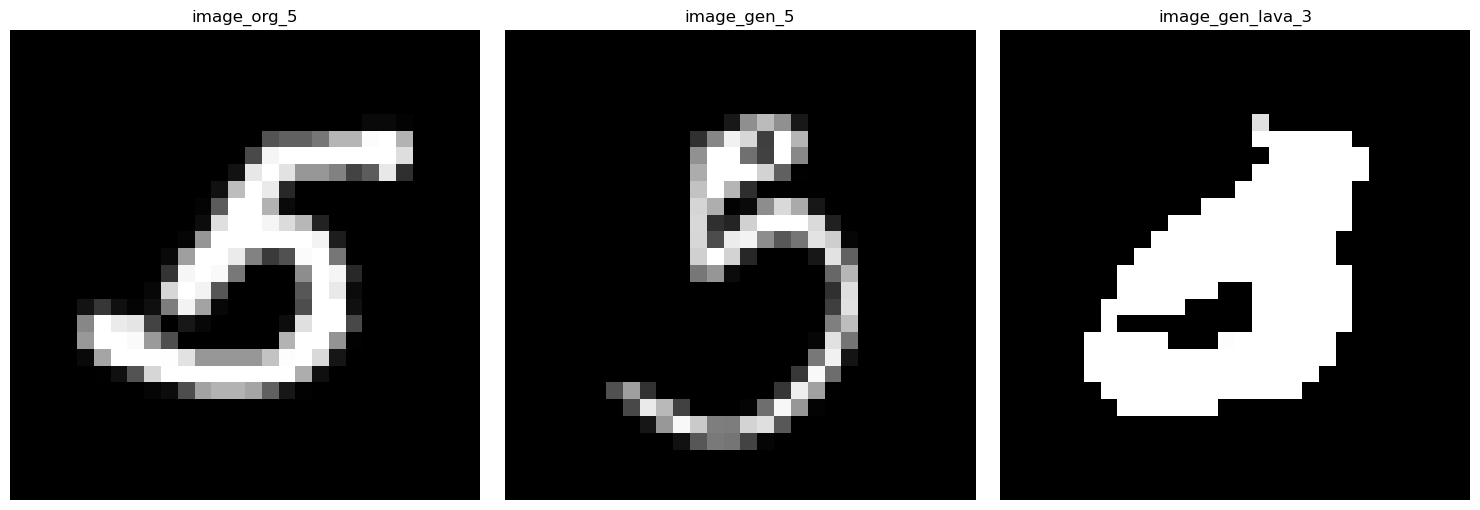

kl_fuzz: 1.2461862564086914
kl_lava: 1.6505473852157593
ws_fuzz: 0.0005428404098280707
ws_lava: 0.0007329858344379784
1/1 [==============================] - 0s 66ms/step
Misclassification achieved at iteration 0
1/1 [==============================] - 0s 18ms/step


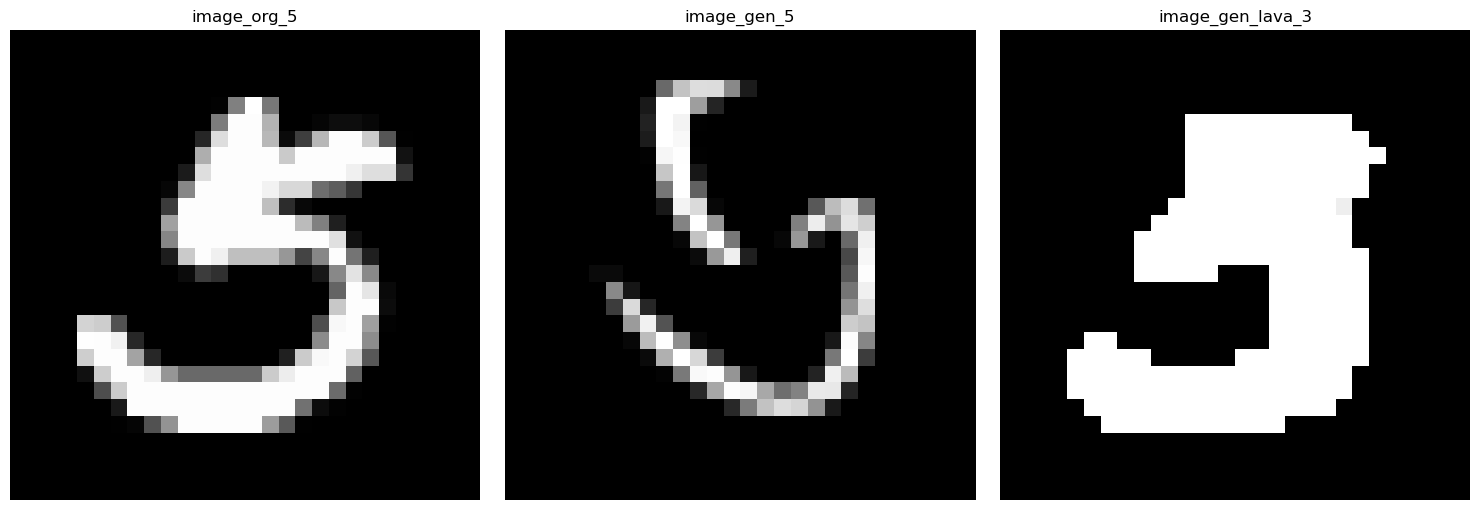

kl_fuzz: 1.0708215236663818
kl_lava: 0.3840670585632324
ws_fuzz: 0.0009909789928616768
ws_lava: 0.0006093347581494231
1/1 [==============================] - 0s 62ms/step
Misclassification achieved at iteration 0
1/1 [==============================] - 0s 18ms/step


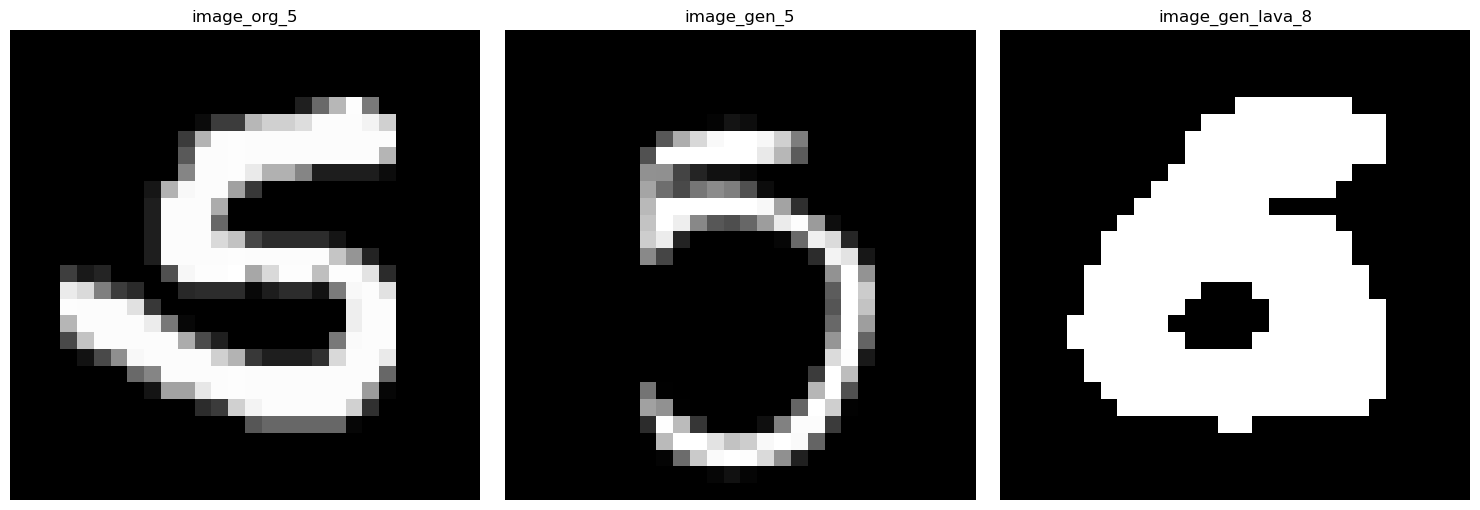

kl_fuzz: 0.8369467258453369
kl_lava: 0.5434051752090454
ws_fuzz: 0.0009193442261694515
ws_lava: 0.0007038775427426283
1/1 [==============================] - 0s 65ms/step
Misclassification achieved at iteration 0
1/1 [==============================] - 0s 18ms/step


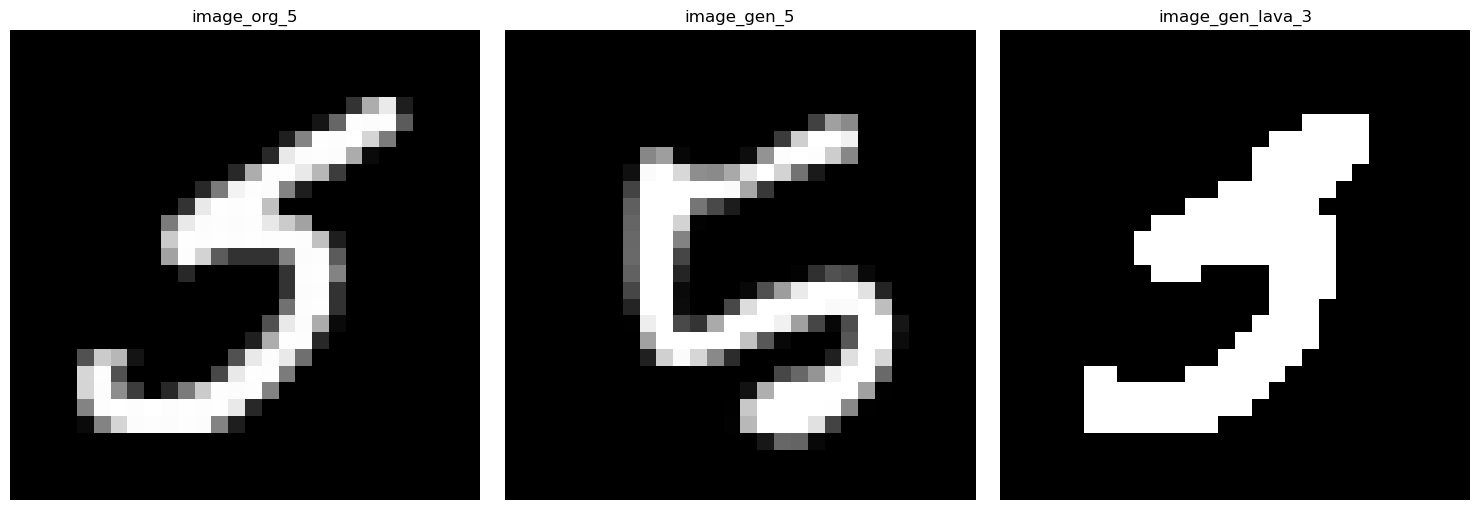

kl_fuzz: 1.6699182987213135
kl_lava: 0.3409048318862915
ws_fuzz: 0.00013110499201836638
ws_lava: 0.00047947837731456336
1/1 [==============================] - 0s 71ms/step
Misclassification achieved at iteration 0
1/1 [==============================] - 0s 18ms/step


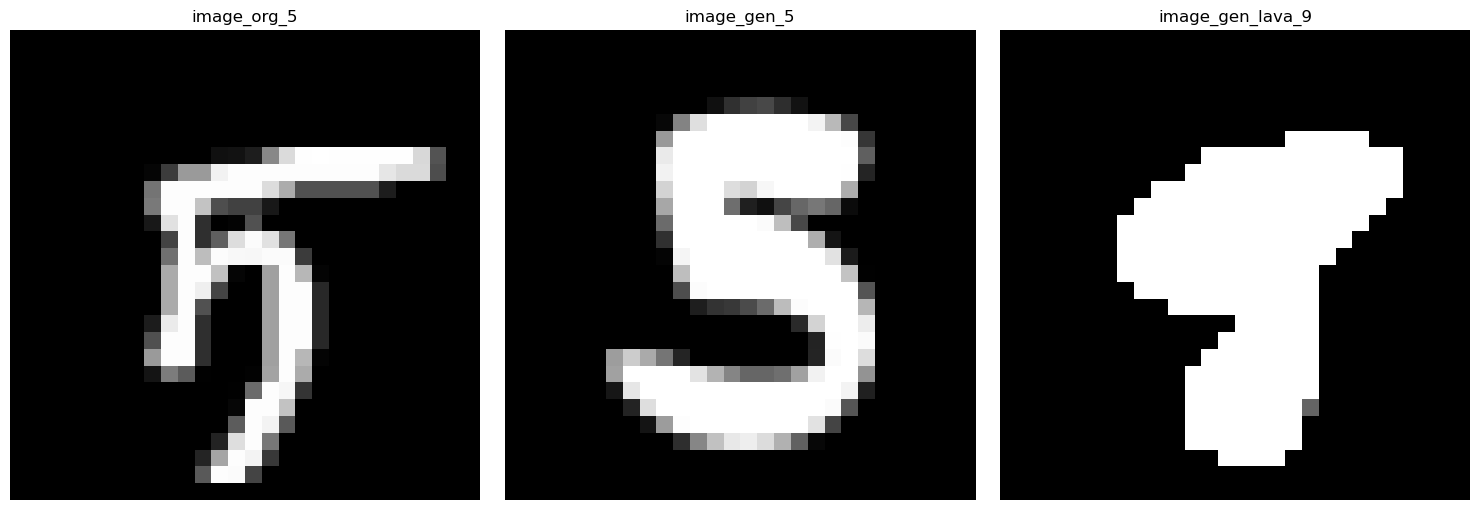

kl_fuzz: 0.9010533690452576
kl_lava: 0.5802730321884155
ws_fuzz: 0.0008362872262416797
ws_lava: 0.0009016299874781323
1/1 [==============================] - 0s 70ms/step
Misclassification achieved at iteration 0
1/1 [==============================] - 0s 17ms/step


In [ ]:
for i in tqdm(range(len(x_view))):

    # calculate fuzz image
    image_org = samples_view[i]
    image_gen = samples_gen[i]

    label_org = sample_labels_view[i]
    # calculate latent variant image
    #image_gen_lava, _ = generate_adversarial_lava(h_view[i], y_onehot_view[i], vae, xai)
    #image_gen_lava, _ = generate_adversarial_lava_step_by_step(h_view[i], y_onehot_view[i], vae, xai, cnn)
    image_gen_lava, _ = generate_adversarial_with_gradient_descent(h_view[i], y_onehot_view[i], 0.01, 10)

    label_gen = np.argmax(cnn.predict(np.array([image_gen]))[0])
    label_lava = np.argmax(cnn.predict(np.array([image_gen_lava]))[0])

    # List of images and their titles
    images = [image_org, image_gen, image_gen_lava]
    titles = [f'image_org_{label_org}', f'image_gen_{label_gen}', f'image_gen_lava_{label_lava}']

    # Plot the images
    if label_lava != label_org:
        plot_image_comparison(images, titles)

        # in image space
        kl_fuzz = kl_divergence(image_org, image_gen)
        kl_lava = kl_divergence(image_org, image_gen_lava)
        print(f"kl_fuzz: {kl_fuzz}\nkl_lava: {kl_lava}")

        ws_fuzz = ws_distance(image_org, image_gen)
        ws_lava = ws_distance(image_org, image_gen_lava)
        print(f"ws_fuzz: {ws_fuzz}\nws_lava: {ws_lava}")
